## VAE for Fashion MNIST : PyTorch

In [214]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.nn import functional as F

import os
import random
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

### Step 0. Device Stepup

In [215]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
random.seed(111)
torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

print("Device : ", device)

Device :  cpu


Hyperparameters

In [216]:
learning_rate = 1e-3
batch_size = 100
epochs = 20

### Step 1. Data -  target class : 10

In [217]:
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

train_dataloader = DataLoader(train_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=10000)

In [218]:
print('train_data :', train_data)
print('test_data :', test_data)

train_data : Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()
test_data : Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()


### Step 2. VAE Model

In [219]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.encoder = nn.Sequential(
            nn.Flatten(),
            nn.Linear(784, 200),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.ReLU()
        )
        self.mean = nn.Linear(100, 10)
        self.logvar = nn.Linear(100, 10)

        self.decoder = nn.Sequential(
            nn.Linear(10, 100),
            nn.ReLU(),
            nn.Linear(100, 200),
            nn.ReLU(),
            nn.Linear(200, 784),
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        return self.mean(h), self.logvar(h)

    def sampling(self, mean, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mean + eps*std

    def forward(self, x):
        mean, logvar = self.encode(x.view(-1, 784))
        z = self.sampling(mean, logvar)
        return self.decoder(z), mean, logvar


model = VAE().to(device)

### Step 3. Loss and Optimizer 

In [220]:
def loss_function(rec_x, x, mean, logvar):
    rec_err = F.binary_cross_entropy(rec_x, x.view(-1, 784), reduction='mean')
    kld = -0.5 * torch.sum(1 + logvar - mean.pow(2) - logvar.exp())

    return rec_err + kld

In [221]:
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

### Step 4. Train the model

In [222]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)

    train_loss = 0
    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)

        # Compute prediction and loss
        pred, mean, logvar = model(X)
        loss = loss_fn(pred, X.view(-1, 784), mean, logvar)
        train_loss += loss.item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= num_batches
    print(f"Train - Avg loss: {train_loss:>8f}", end = "  ")

    return train_loss

def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss = 0

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)

            pred, mean, logvar = model(X)
            test_loss += loss_fn(pred, X.view(-1, 784), mean, logvar).item()

    test_loss /= num_batches
    print(f"Test - Avg loss: {test_loss:>8f}")

    return test_loss

In [223]:
train_loss = []
test_loss = []
for t in range(epochs):
    print(f"Epoch {t+1} :", end= "  ")
    loss = train_loop(train_dataloader, model, loss_function, optimizer)
    train_loss.append(loss)

    loss_t = test_loop(test_dataloader, model, loss_function)
    test_loss.append(loss_t)

print("Done!")

Epoch 1 :  Train - Avg loss: 0.790993  Test - Avg loss: 3.961215
Epoch 2 :  Train - Avg loss: 0.720865  Test - Avg loss: 2.602182
Epoch 3 :  Train - Avg loss: 0.711634  Test - Avg loss: 2.034437
Epoch 4 :  Train - Avg loss: 0.707064  Test - Avg loss: 1.735487
Epoch 5 :  Train - Avg loss: 0.704310  Test - Avg loss: 1.553630
Epoch 6 :  Train - Avg loss: 0.702396  Test - Avg loss: 1.429107
Epoch 7 :  Train - Avg loss: 0.700934  Test - Avg loss: 1.337701
Epoch 8 :  Train - Avg loss: 0.699722  Test - Avg loss: 1.267068
Epoch 9 :  Train - Avg loss: 0.698700  Test - Avg loss: 1.210379
Epoch 10 :  Train - Avg loss: 0.697800  Test - Avg loss: 1.163600
Epoch 11 :  Train - Avg loss: 0.696976  Test - Avg loss: 1.124367
Epoch 12 :  Train - Avg loss: 0.696220  Test - Avg loss: 1.090764
Epoch 13 :  Train - Avg loss: 0.695536  Test - Avg loss: 1.061560
Epoch 14 :  Train - Avg loss: 0.694878  Test - Avg loss: 1.035879
Epoch 15 :  Train - Avg loss: 0.694261  Test - Avg loss: 1.013123
Epoch 16 :  Train -

### Plot the Training/Test loss

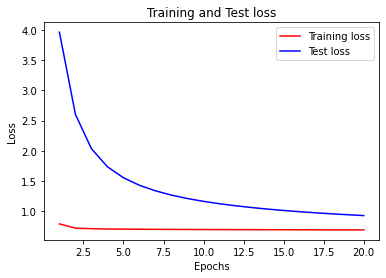

In [224]:
epochs = np.arange(1, epochs+1)
plt.plot(epochs, train_loss, 'r', label='Training loss')
plt.plot(epochs, test_loss, 'b', label='Test loss')
plt.title('Training and Test loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

### Plot multiple images

In [225]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

### Plot images

In [226]:
def plot_image(image):
    plt.imshow(image, cmap="binary")
    plt.axis("off")

### Show Reconstruction Images

In [227]:
def show_reconstructions(model, dataloader=test_dataloader, n_images=5):
    with torch.no_grad():
      images, y = next(iter(dataloader))
      print(images.shape)
      rec_images, _, _ = model(images[:n_images].to(device))

    images = images.squeeze().cpu().numpy()
    rec_images = rec_images.reshape(-1, 28, 28).cpu().numpy()

    print(images.shape, rec_images.shape)
    fig = plt.figure(figsize=(n_images * 1.5, 3))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(rec_images[image_index])


### Show Original and Reconstruected Images

torch.Size([10000, 1, 28, 28])
(10000, 28, 28) (5, 28, 28)


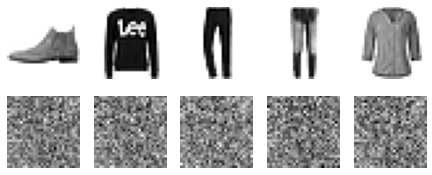

In [228]:
show_reconstructions(model, test_dataloader)

In [229]:
### Step 5. Generate Images

In [230]:
codings = tf.random.normal(shape=[12, codings_size])
images = variational_decoder(codings).numpy()
plot_multiple_images(images, 4)
save_fig("vae_generated_images_plot", tight_layout=False)

codings_grid = tf.reshape(codings, [1, 3, 4, codings_size])
larger_grid = tf.image.resize(codings_grid, size=[5, 7])
interpolated_codings = tf.reshape(larger_grid, [-1, codings_size])
images = variational_decoder(interpolated_codings).numpy()

NameError: ignored

### Plot the Intepolated Images

In [ ]:
plt.figure(figsize=(10, 5))
for index, image in enumerate(images):
    plt.subplot(5, 7, index + 1)
    if index%7%2==0 and index//7%2==0:
        plt.gca().get_xaxis().set_visible(False)
        plt.gca().get_yaxis().set_visible(False)
    else:
        plt.axis("off")
    plt.imshow(image, cmap="binary")
    
save_fig("semantic_interpolation_plot", tight_layout=False)
